# CSCI-635-01 Project2
Yifei Sun, Shuo Yao, Zhuo Liu, Zongge Xie

Facing the COVID-19 global pandemic, a large amount of scholarly articles has been created everyday, making it very difficult for medical researchers to keep up with the latest information in their research area. 

Problem 1: Having the data of articles in a certain research area, how many types of research focuses are there in these articles? 

Problem2: Given some new articles in this research area, what are these articles focusing on? 

Our goal is to use what we have learned from the CSCI-635 class to build up a program which can be able to figure out how many 'specific research focuses' are there for a given research area, and also can be able to classify new articles into certain 'specific research focuses'. Even though what we have built in this project is a preliminary model that requires lots of modifications by people with a medical background, it still builds up a foundation for an effective system. Our program is suitable for any research areas but we decided to focus on diagnostics and surveillance in our implementation (Task: What do we know about diagnostics and surveillance?).

The strategy of our approach, including development process explanation and subproblem solution, is showing below:

Having the input data, which includes all available articles, the first step is to filter these articles and only keep the article within the area of diagnostics and surveillance.

1. How can we filter the data to the research area of diagnostics and surveillance? Our attempt to solving this problem is quite straight-forward. We've collected a list of words related to 'diagnostic' and 'surveillance'. When preprocessing each article data, if the article contains words in the word list we have created, this article will be considered as related to the research area of diagnostics and surveillance, otherwise, it will be considered as not related and ignored.

The 'filtered' data will go through a preprocessing function for removing stopwords and lemmatization. The output will be used for summarizing the types of research that focuses on the research area.

2. How can we figure out how many types of research focuses are there in this research area? With no medical background, it's not realistic for us to summarize research focuses on and related word lists accurately. What we proposed to do is first perform text feature extraction and dimensionality reduction on the research area article data, then try kmeans with the different number of k to perform clustering on this data. We will use evaluation tools helping us to decide what's the best choice of k.

Now we have found a good clustering of data, it's time to determine the 'meaning' (the type of research focuses) of each cluster.

3. When we find a good clustering of data, how can we determine the meaning of each cluster? In our approach, the word cloud has been chosen to solve this topic modeling problem. These k word cloud images will be created for the corresponding k clusters. We think word cloud is the most 'visualized' way to show the significance of words in certain clusters. These word clouds can help professional medical researchers to quickly target the research focuses on these clusters. At this point, we just simply label them as class 0 to k-1.

Till this point, problem 1 has been solved, now it's time to solve problem 2. Previous steps produce us with the class label for each article in the data. We can use this data to train a classifier for article label classification. So for a new input article, feature extraction and dimensionality reduction will be applied with the model we trained with the previous dataset, and the article label classification will classify which label (the type of research focuses) this article will have.

In [1]:
import pdb
import numpy as np
import pandas as pd
import json as js
import nltk
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from nltk.stem.porter import *
from nltk.stem.lancaster import LancasterStemmer
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import silhouette_score
import copy
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os

## Data preprocessing
Read the article data from given dataset, filter and keep data in the research area of diagnostics and surveillance. Preprocess the data by removing stop words and lemmatization.

In [2]:
# stemmer = LancasterStemmer() we decided not to use stemmer base on experiment analysis

def lemmatize_stemming(text):
    """
    Lemmatization 
    """
    return WordNetLemmatizer().lemmatize(text, pos='n') # extract Noun from text


def preprocess_clean(text):
    """
    Preprocess including removing stop words
    and lemmatization
    """
    
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result


def preprocess_data():
    """
    Load and filter data
    """
    
    i = 0
    
    # word related to diagnositics and surveillance
    related_words = ['diagnostic', 'diagnostics', 'symptomatic', 'diagnosing', 'diagnosis', 'clinical', 
                     'diagnose', 'diagnoses', 'detection', 'screening', 'analytical', 'assessment',
                    'prognosis', 'surveillance', 'monitoring', 'reconnaissance']
    
    corona_pos_all_text = []
    
    """
    walk through all the files under specific directory
    """
    for dirname, _, filenames in os.walk('./CORD-19-research-challenge/comm_use_subset'):
        for filename in filenames:
            
            topic_related = False
            
            """
            show data loading progress
            """
            if i % 1000 == 0:
                print ("Working (number %d)..." % i)

            """
            only load json files
            """
            if filename.split(".")[-1] == "json":

                f = open(os.path.join(dirname, filename))
                j = js.load(f)
                f.close()

                """
                some articles contain abstract while others not 
                """
                try:
                    abstract_text = ' '.join([x['text'] for x in j['abstract']])
                except:
                    abstract_text = ""

                """
                body text and abstract consist the whole body text
                """
                body_text = ' '.join(x['text'] for x in j['body_text'])
                body_text += " " + abstract_text
                
                for related_word in related_words:
                    if related_word in body_text:
                        topic_related = True
                        break
                if topic_related:
                    i += 1
                    corona_pos_all_text.append(body_text)
    return corona_pos_all_text


In [3]:
# Load and preprocess data.
corona_pos_all_text = preprocess_data()
corona_pos_all_text = [preprocess_clean(x) for x in corona_pos_all_text]
print("Data lemmatized")

Working (number 0)...
Working (number 0)...
Working (number 1000)...
Working (number 2000)...
Working (number 3000)...
Working (number 3000)...
Working (number 4000)...
Working (number 5000)...
Working (number 6000)...
Working (number 7000)...
Working (number 8000)...
Working (number 9000)...
Working (number 10000)...
Working (number 10000)...
Working (number 11000)...
Working (number 12000)...
Working (number 13000)...
Working (number 14000)...
Working (number 15000)...
Working (number 16000)...
Data lemmatized


## Text feature extraction and principle component analysis 
TF-IDF has been selected for text feature extraction. Only the top 5000 features ordered by term frequency across the cropus has been used. The data with extractd feature then goes trough a dimensioality reduction process utilizing principle components analysis.

In [4]:
def vectorize_PCA(corona_pos_all_text):
    corpus = []
    for t in corona_pos_all_text:
        corpus.append(' '.join(t))
    
    vectorizer = TfidfVectorizer(max_features=5000) #initialize Tfidf Vectorizer
    corpus_matrix = vectorizer.fit_transform(corpus) # fit the Vectorizer, and generate corpus matrix
    word_feature_list = vectorizer.get_feature_names()# get feature name. There should be 5000 words extracted from text.
    
    corpus_matrix = corpus_matrix.toarray()
    
    # wrt to pca
    # COLUMNS of u are the eigen vectors
    # s are the square roots of the eigenvalues
    # rows are sorted by eigenvalue in descending order
    # shape of corpus_matrix is m*n, then u is (m,m) or (m,k), w is (n,n) or (k,n), k is min(m,n)
    u,s,w = np.linalg.svd(corpus_matrix.T)
    
    num_compon = 50 # we plan to reudce the dimension into 50
    corpus_reduced = corpus_matrix.dot(u[:,:num_compon])
    
    # use the plot to determine the best number of n components.
    plt.plot(s*s)
    plt.show()

    return corpus_reduced, word_feature_list, vectorizer, u[:,:num_compon]

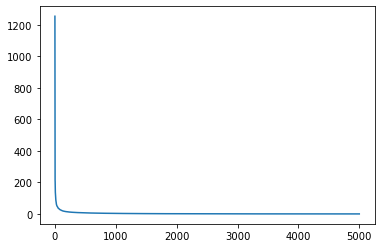

In [5]:
corpus_matrix, word_feature_list, vectorizer, eigenvectors=vectorize_PCA(corona_pos_all_text)

From the figure showing above, we can see that the best number of n components happens around n=50.

## Unsupervised learning (KMeans) 
Now we are trying to group theses articles. We use kmeans as our clustering algorithm. At the same time, in order to figure out the best value of hyperparameter 'k', we use Elbow method and Silhouette analysis to evaluate clustering results with different k. The Elbow method is based on the sum of squared distance (SSE) between data points and their assigned cluster's centroids. In addition, we also implemented the Silhouette analysis to compare and double-check our selection of k.

In [6]:
def kmeans(corpus_matrix, k):
    """
    kmeans is unsupervised learning, we don't have to use label for kmeans
    label array is being used for SVM method
    """
    kmeans3= KMeans(n_clusters=k,max_iter=150,n_jobs=12, algorithm ='full')

    """
    y_kmeans3 contains the information that 
    each sample belongs to its corresponding cluster
    """
    y_kmeans3 = kmeans3.fit_predict(corpus_matrix)

    centers = kmeans3.cluster_centers_
    
    sse = kmeans3.inertia_
    """
    centers.shape if equal to (m,n)
    m is number of centers
    n is number of features
    """
    return y_kmeans3, centers, sse

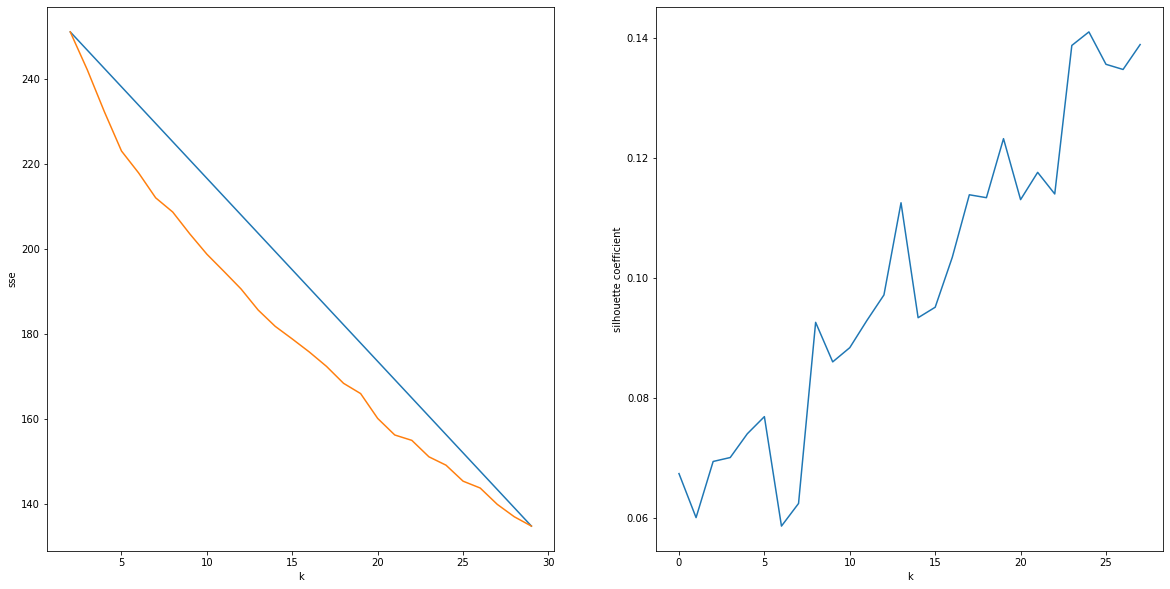

In [40]:
corpus_copy = copy.copy(corpus_matrix)
np.random.shuffle(corpus_copy)

sse_list = []
silhouette_list = []

# try the number of k from 2 to 29, see which is the best one.
for k in range(2, 30):
    indices, centers, sse=kmeans(corpus_copy[:1000], k)
    sse_list.append(sse)
    silhouette_list.append(silhouette_score(corpus_copy[:1000],indices,metric='euclidean'))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot([2, 29], [sse_list[0], sse_list[-1]])
plt.plot(list(range(2, 30)), sse_list)
plt.xlabel('k')
plt.ylabel('sse')

plt.subplot(1,2,2)
plt.plot(silhouette_list)
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.show()

From the figure showing above, we can see that a better k values are betwen 8 and 12. We will choose k = 8 at this point.

## Word cloud
Perform clustering of data with k = 8. When having the clustering result, it's time to use word cloud to visualize the 'meaning' (the type of research focuses) of each cluster. Implementation and results of the word cloud on 8 clusters are showing below. 

In [7]:
def word_cloud_advanced(corona_pos_all_text):
     """
    Implementation of word cloud.
    """
    stopwords=set(STOPWORDS)
    res = ''
    for text in corona_pos_all_text:
        for word in text:
            res += word + ' '

    # generate wordcloud image
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(res)

    # plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [8]:
def kmeans_wordCloud(corona_info, indices):
    """
    length of res corresponds to number of clusters
    """
    res=[[] for _ in range(len(set(indices)))]
    for i in range(len(indices)):
        res[indices[i]].append(corona_info[i][:])

    """
    for different clusters show different wordCloud
    """
    for subarray in res:
        word_cloud_advanced(subarray)

In [9]:
def process_word(text, word_feature_list):
    """
    Only keep the words with the top-5000 tfidf words.
    """
    result = []
    for p in text:
        temp = []
        for w in p:
            if w in word_feature_list: # if the word is not one of our 5000 most representative words, just skip it
                temp.append(w)
        if len(temp) != 0:
            result.append(temp)
    return result

In [10]:
# process all text with only keeping the the top 5000 words ordered by term frequency across the cropus
corona_pos_all_text = process_word(corona_pos_all_text, word_feature_list)

In [11]:
# perform kmeans on the data with k=8
indices,_,_=kmeans(corpus_matrix,8)

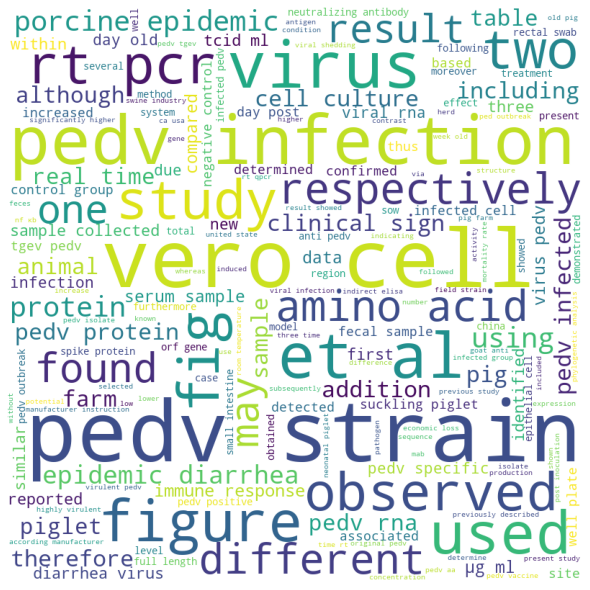

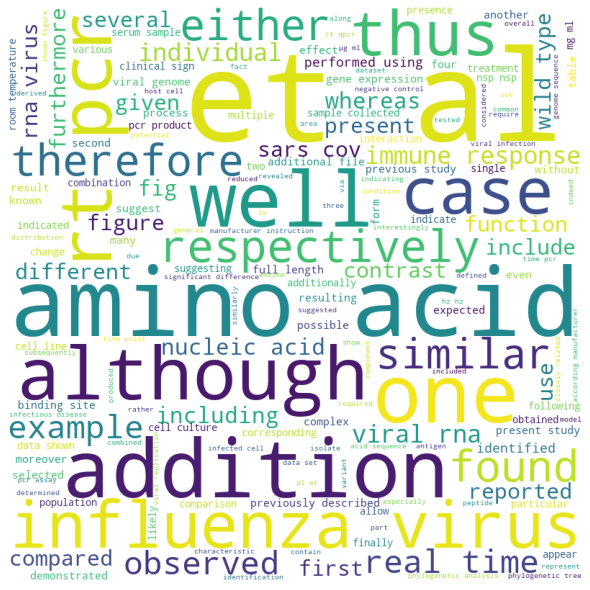

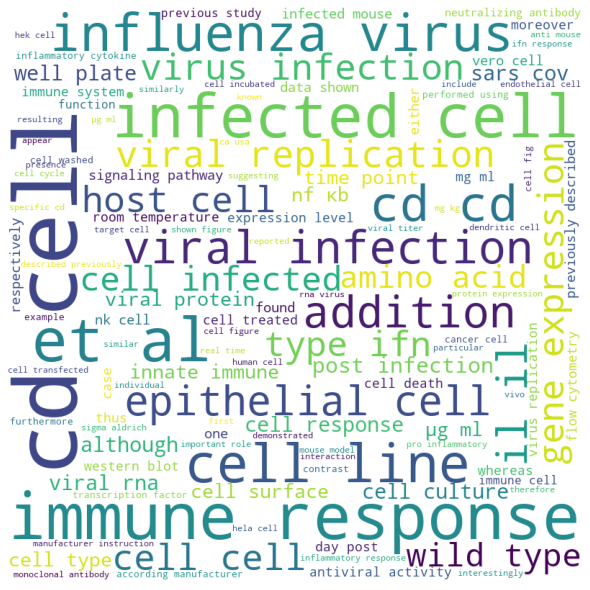

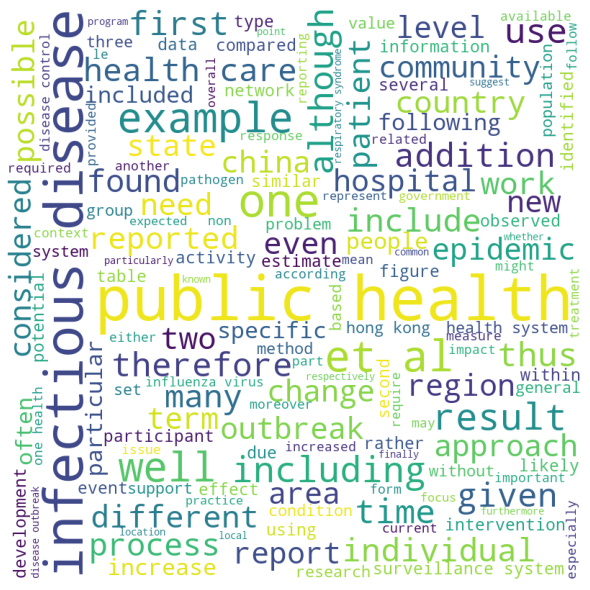

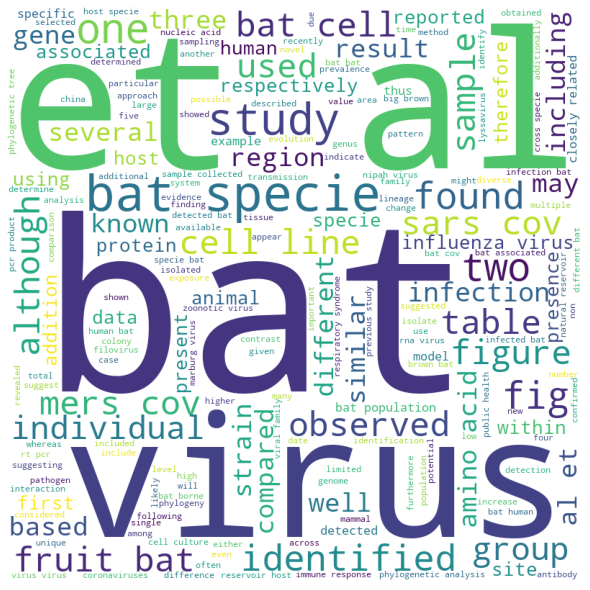

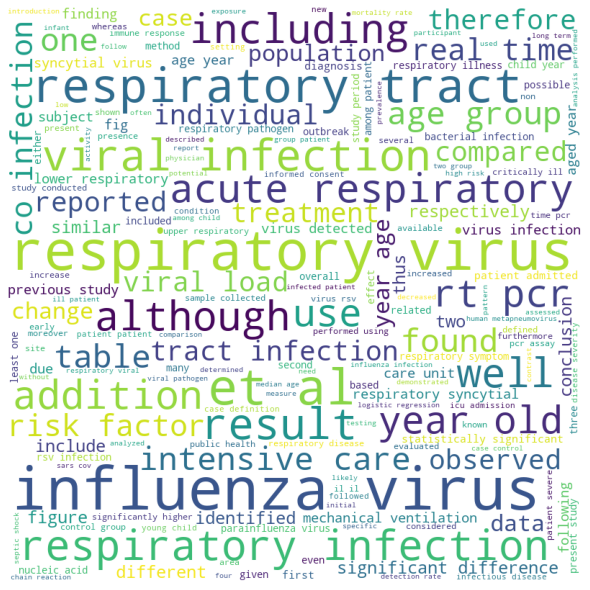

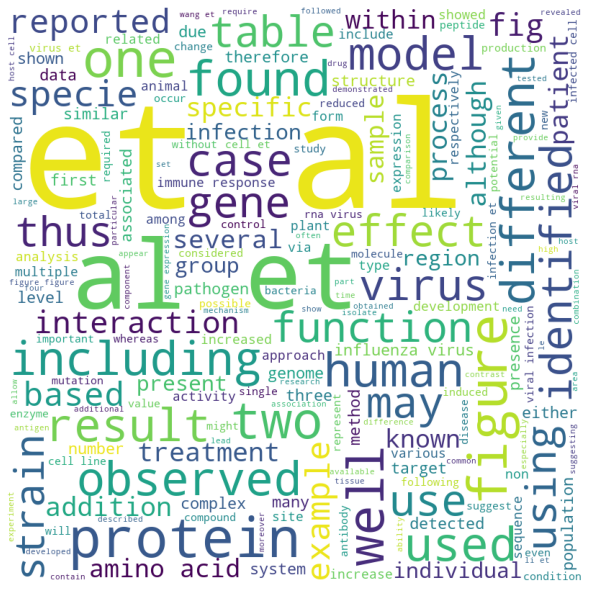

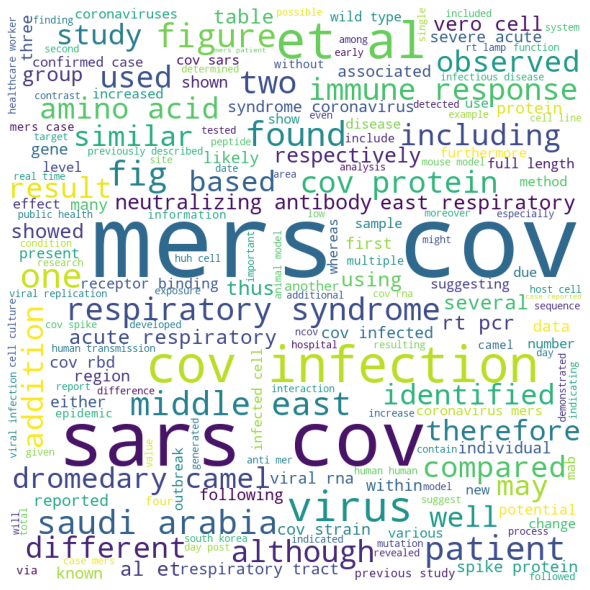

In [12]:
# compute and display word cloud for each cluster
kmeans_wordCloud(corona_pos_all_text,indices)

From the word cloud result, we can see that the word clouds of diffrent clusters have different significance of words and can provide us with impressions of the topics. 

However, we can still see some of the 'useless' words such as 'et al' existed. More preprocessing needs to be done to solve this problem. 

Also, analysis by medical researchers needs to be done to give each group a technical research topic label (some of the group may be labeled as not related).

## Supervised learning (train article label classifier)
### Data splitting
To train and test the article label classifier, peroform 2/3, 1/3 train, test split.

Three classification model has been implemented to see which on works the best.

In [13]:
# data spliting
training_features = corpus_matrix[0:12000,:]
testing_features = corpus_matrix[12000:,:]
training_labels = indices[0:12000]
testing_labels = indices[12000:]

### RandomForest Model

In [14]:
clf = RandomForestClassifier(n_estimators=300, n_jobs=12, bootstrap=False)
clf.fit(training_features, training_labels)
y_pred = clf.predict(testing_features)
print("Accuracy:", accuracy_score(testing_labels, y_pred))
print(confusion_matrix(testing_labels, y_pred))
print(classification_report(testing_labels, y_pred))

Accuracy: 0.9130167700718718
[[ 232   45    9    6    0    0    7    0]
 [   0 4414  530   74    3   66    7   28]
 [   0  107 3944    0    9   19    0   21]
 [   0   39    8 2864    0   45    2   13]
 [   0    7    2    3  298    2    3    4]
 [   0   63   10  105    0 1898    5   15]
 [   0   45   59   11    1   16  564    3]
 [   0    3    6    6    3    5    1  649]]
              precision    recall  f1-score   support

           0       1.00      0.78      0.87       299
           1       0.93      0.86      0.90      5122
           2       0.86      0.96      0.91      4100
           3       0.93      0.96      0.95      2971
           4       0.95      0.93      0.94       319
           5       0.93      0.91      0.92      2096
           6       0.96      0.81      0.88       699
           7       0.89      0.96      0.92       673

    accuracy                           0.91     16279
   macro avg       0.93      0.90      0.91     16279
weighted avg       0.92      0

### SVM rbf kernel

In [15]:
rbf_kernel = SVC(kernel='rbf')
rbf_kernel.fit(training_features,training_labels)
y_pred = rbf_kernel.predict(testing_features)
print("Accuracy:", accuracy_score(testing_labels, y_pred))
print(confusion_matrix(testing_labels, y_pred))
print(classification_report(testing_labels, y_pred))

Accuracy: 0.9042324467104859
[[ 274   21    0    4    0    0    0    0]
 [   0 4474  461   84    8   62   19   14]
 [   1  187 3860    0   15   13    2   22]
 [   0   81   15 2798    0   60    0   17]
 [   0    5    0    0  312    0    0    2]
 [   0  129   21  109    0 1816    5   16]
 [   0   67   41   17    2    6  563    3]
 [   0   39    1    4    3    3    0  623]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.95       299
           1       0.89      0.87      0.88      5122
           2       0.88      0.94      0.91      4100
           3       0.93      0.94      0.93      2971
           4       0.92      0.98      0.95       319
           5       0.93      0.87      0.90      2096
           6       0.96      0.81      0.87       699
           7       0.89      0.93      0.91       673

    accuracy                           0.90     16279
   macro avg       0.92      0.91      0.91     16279
weighted avg       0.91      0

### 1 Nearest Neighbour

In [16]:
from sklearn.neighbors import KDTree
from collections import Counter

def predict(indice, training_target):
    total = []
    for i in indice:
        total.append(training_target[i])
    return Counter(total).most_common(1)[0][0]

def predictions(ind, training_target):
    prediction = []
    for i in range(len(ind)):
        indice = ind[i]
        prediction.append(predict(indice, training_target))
    return prediction

tree = KDTree(training_features, leaf_size=100, metric='manhattan')
dist, ind = tree.query(testing_features, k=1)
y_pred = predictions(ind, training_labels)
print("Accuracy:", accuracy_score(testing_labels, y_pred))
print(confusion_matrix(testing_labels, y_pred))
print(classification_report(testing_labels, y_pred))

Accuracy: 0.799741998894281
[[ 248   40    2    6    0    0    3    0]
 [   1 3920  754  203   16  157   57   14]
 [   0  629 3376   14    9   48    8   16]
 [   0  142   44 2650    0  108    4   23]
 [   0    3    6    1  303    0    0    6]
 [   0  196   56  163    0 1662    8   11]
 [   0  167  109   47    3   25  340    8]
 [   0   83   17   29   14    8    2  520]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       299
           1       0.76      0.77      0.76      5122
           2       0.77      0.82      0.80      4100
           3       0.85      0.89      0.87      2971
           4       0.88      0.95      0.91       319
           5       0.83      0.79      0.81      2096
           6       0.81      0.49      0.61       699
           7       0.87      0.77      0.82       673

    accuracy                           0.80     16279
   macro avg       0.84      0.79      0.81     16279
weighted avg       0.80      0.

From the test result showing above, we can see that Random Forest Model works the best among all these three models. So we will use this model as our new article label classifier.
We can find that the classifier all performed very well on our testing set. However, This does not guarantee its accuracy in practical applications. This is because the test data is also considered and applied to the KMeans algorithm. They also have been grouped. As we can not inference their labels in reality, KMeans algorithm is the strategy we applied to label them. This is why all three classifier models achieve a high test accuracy rate. Especially, KNN classifier achieved 80% accuracy in 8 classification problems also validates our interpretation.

However, this does not mean that we get nothing from the results. SVM rbf kernel can classify data in high-dimensional feature space. Through the test results, it is found that SVM has a good classification effect on this set of data, and the accuracy rate reaches 90.42%. From this result, we can know that the data has been well clustered. And the clustering effect of our Kmeans algorithm is reliable.

## Pipline for classifying new article labels

Given the research area of diagnositics and surveillance, the input article will first be tested to see wether it's related to this area or not. If this article is related to diagnositics and surveillance, text feature extraction and dimensionality reduction will be applied on it with the model we trained with the previous dataset. Then article label classification will classify which label (the type of research focuses) this article will have.

In [17]:
# word related to diagnositics and surveillance
related_words = ['diagnostic', 'diagnostics', 'symptomatic', 'diagnosing', 'diagnosis', 'clinical', 
                     'diagnose', 'diagnoses', 'detection', 'screening', 'analytical', 'assessment',
                    'prognosis', 'surveillance', 'monitoring', 'reconnaissance']

corona_pos_all_text = []

f = open('./test1.json')
j = js.load(f)
f.close()

"""
some articles contain abstract while others not 
"""
try:
    abstract_text = ' '.join([x['text'] for x in j['abstract']])
except:
    abstract_text = ""

"""
body text and abstract consist the whole body text
"""
body_text = ' '.join(x['text'] for x in j['body_text'])
body_text += " " + abstract_text
topic_related = False        
for related_word in related_words:
    if related_word in body_text:
        print('This resource is related to diagnositics and surveillance')
        topic_related = True
        break
if topic_related:
    corona_pos_all_text.append(body_text)


corona_pos_all_text = [preprocess_stem_clean(x) for x in corona_pos_all_text]
print("Data lemmatized")

corpus = []
for t in corona_pos_all_text:
    corpus.append(' '.join(t))

corpus_matrix = vectorizer.transform(corpus) # transform raw text data into 5000 dimensional features
corpus_matrix = corpus_matrix.toarray()
corpus_reduced = corpus_matrix.dot(eigenvectors) # reduce the dimension into 50

This resource is related to diagnositics and surveillance
Data lemmatized


In [20]:
y_pred = clf.predict_proba(corpus_reduced)
class_idx = np.argmax(y_pred)
print('This article has focus topic idx: ', class_idx)

This article has focus topic idx:  6


## Conclusion and Discussion

We tried to solve the problem through unsupervised learning. And our contribution are:

    Filtering the related words of the data, and use Tfidf to clean the data.
    Experimenting with Kmeans and trying to find the best clustering result.
    Applying wordcloud to interpret the meaning of each cluster.
    Implementing pipline for classifying new article labels.
When it comes to unsupervised learning, researchers often have difficulties in assigning practical meaning to each cluster. WordCloud provides us with a way to interpret data. With this method, we can carry out specific analysis of the text in it, thus digging out a deeper meaning. 


## Reference
1. https://www.kaggle.com/christopherhoman/homan-aiai-covid
2. https://www.kaggle.com/maksimeren/covid-19-literature-clustering